## Importing Modules
We will start by importing some modules that will be useful throughout much of the subsequent code in this tutorial.

In [63]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from math import log, sqrt
from scipy.stats import norm
from tqdm import tqdm
from typing import List

# Make plots look nice
sns.set()
sns.set_context("notebook")
sns.set_style("whitegrid")

## Creating the Stochastic MAB Problems

In the real world, we normally don't have direct access to the distributions over rewards that are associated with our actions (arms). Normally, these distributions implicitly exist somewhere, and our reward observations only emerge as we interact with some processes (e.g., users, complex simulations, etc.).

For simplicity, here we just create a bunch of explicit distributions that we can sample from. This gives us a very simple simulation, and lets us focus purely on the implementation of the action-selection algorithms.

More specifically, we create a suite of 200 different MAB problems, where each
individual MAB problem has $k = 10$ arms. Every arm has a mean reward $\mu_i$
which is sampled from a Normal distribution with mean $0$ and unit variance.
Then, every arm itself also again samples its rewards from a Normal distribution
with its own mean $\mu_i$, and unit variance. This test setup is the 10-armed
Testbed as described in Section 2.3 of the second edition of Sutton and Barto's *Reinforcement Learning* book, except we use only 200 instead of 2000 MABs (to make our experiments go faster).

In [64]:
np.random.seed(2077)    # fix seed to make everything below reproducible
k = 10      # number of arms per MAB problem
num_mab_problems = 200
time_steps_per_problem = 1000

# Matrix of means, where the i'th row contains the means of all arms for the
# i'th MAB problem
arm_means = np.random.normal(loc=0.0, scale=1.0, size=(num_mab_problems, k))

## Random MAB Algorithm

As a start, we'll implement a very simple and silly Random MAB algorithm, which always selects arms uniformly at random. It is not intelligent at all, but it is very easy example, and a useful sanity check: if any of our algorithms ever do worse than this, something is probably wrong!

In [65]:
class RandomAlg:
  """
  Random MAB algorithm, which selects actions uniformly at random.
  """

  def __init__(self):
    """
    This is where we could initialise any variables we wanted to,
    but for the random algorithm this is not necessary, so we do
    nothing.
    """
    pass

  def reset(self) -> None:
    """
    Reset any data that we stored. Called when we start with a
    new MAB problem. The random algorithm doesn't store any
    data, so nothing to reset here.
    """
    pass

  def choose_arm(self) -> int:
    """
    :return: Arm, in [0, k), selected uniformly at random.
    """
    return np.random.randint(low=0, high=k)

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.
    The simple random algorithm doesn't care and does nothing.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    """
    pass

  def __str__(self):
    return "Random"


## Baseline Sequential Halving Algorithm for MAB

Basic Algorithm:


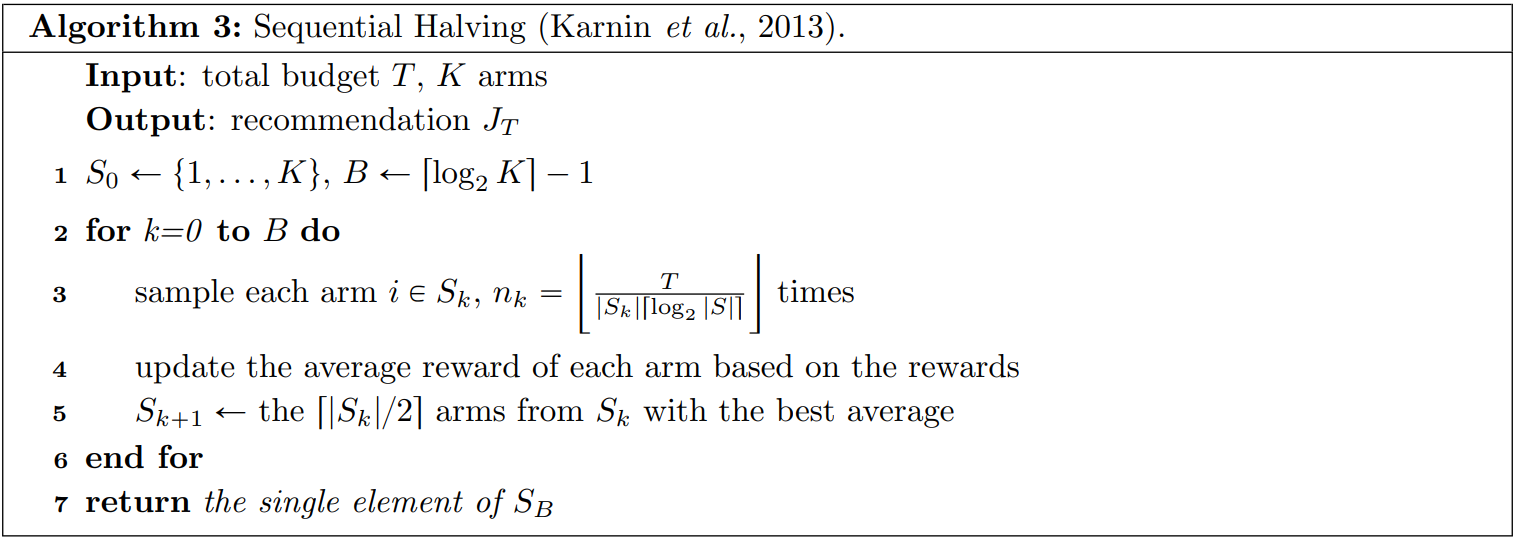

In [66]:

import math


class SequentialHalvingAlg:
  """
  Baseline sequential halving algorithm using a discrete iteration budget (as per Karnin et al., 2013).
  """
  
  rounds = math.ceil(math.log2(k)) - 1 #Amount of rounds to be used in the algorithm/amount of times the amount of considered arms will be halved
  
  def __init__(self,return_hist=False):
      self.current_arms = range(k) #A list of all arms that the algorithm cares about. Will be sequentially halved ;)
      self.current_arm = self.current_arms[0] #Keeping track of the current arm to pull
      self.current_rewards = [0] * k #The rewards that the algorithm has observed for each arm
      self.visits = [0] * k #The amount of times that the algorithm has pulled each arm
      self.total_rewards = [0] * k #The total rewards that the algorithm has observed for each arm
      self.considered_arms_amt = k #The amount of arms that the algorithm is currently considering
      self.sample_count_per_arm = self.get_dist_per_arm(k) #Amount of times by which each arm should be sampled (as per Karnin et al algorithm).
      self.current_iteration = 0 
      self.budget_left = time_steps_per_problem
      self.current_round = 1
      self.return_hist = return_hist
      self.hist = [] #Stores history of arms pulled

  
  
  """
  Retruns the amount of budget to be allocated to each arm.
  """
  def get_dist_per_arm(self, num_arms):
      return math.floor(time_steps_per_problem/(num_arms*math.ceil(math.log2(num_arms))))
    
  
  def reset(self) -> None:
    self.current_arms = range(k)
    self.current_arm = self.current_arms[0]
    self.current_rewards = [0] * k
    self.visits = [0] * k 
    self.total_rewards = [0] * k 
    self.considered_arms_amt = k
    self.sample_count_per_arm = self.get_dist_per_arm(k)
    self.budget_left = time_steps_per_problem
    self.current_round = 1
    self.hist = [] #Stores history of arms pulled
    self.budget_left = time_steps_per_problem
  

  def choose_arm(self) -> int:
    #print(f"current_arm: {self.current_arm} current index: {self.current_arms.index(self.current_arm)} current_iteration: {self.current_iteration} considered_arms_amt: {self.considered_arms_amt} current_round: {self.current_round} budget_left: {self.budget_left} sample_count_per_arm: {self.sample_count_per_arm} arms left: {len(self.current_arms)}")
    if(self.considered_arms_amt < 1): return self.current_arm
    
    
    if self.current_iteration == self.sample_count_per_arm:
      self.current_iteration = 0
      
      
      #Check to see if we have used every arm the amount of times we should have
      if self.current_arms.index(self.current_arm) + 1 == self.considered_arms_amt:
        #If we have, we halve the amount of considered arms based on rewards and reset the current arm to the first arm in the list
        
        # Pair each arm with its corresponding reward, sort the pairs, and extract the arms
        self.current_arms, self.current_rewards = zip(*sorted(zip(self.current_arms, self.current_rewards), key=lambda x: x[1], reverse=True))
        self.current_arms = list(self.current_arms)
        self.current_rewards = list(self.current_rewards)
        
        
        self.current_arms = self.current_arms[:math.ceil(self.considered_arms_amt/2)] #Take top half of the list
        self.current_rewards = self.current_rewards[:math.ceil(self.considered_arms_amt/2)]
        self.considered_arms_amt = len(self.current_arms)
        # self.considered_arms_amt = math.ceil(self.considered_arms_amt/2)
        self.current_round = self.current_round + 1
        
        self.budget_left = self.budget_left/2 #FIXME: Is this correct or should it be rounded up before use in the halving method?
        
        # budget_left = self.budget_left
        if self.considered_arms_amt == 1:
          self.sample_count_per_arm = self.budget_left
        else:
          self.sample_count_per_arm = self.get_dist_per_arm(self.considered_arms_amt)
          
        self.current_arm = self.current_arms[0]
        
        if self.return_hist: self.hist.append(self.current_arm)
        
        return self.current_arm
      
     
      self.current_arm = self.current_arms[self.current_arms.index(self.current_arm)+1]
      
      if self.return_hist: self.hist.append(self.current_arm)
      return self.current_arm
    else:
      self.current_iteration = self.current_iteration + 1
      if self.return_hist: self.hist.append(self.current_arm)
      return self.current_arm

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    
    """
    self.visits[self.current_arms.index(arm)] = self.visits[self.current_arms.index(arm)] + 1
    self.total_rewards[self.current_arms.index(arm)] = self.total_rewards[self.current_arms.index(arm)] + reward
    self.current_rewards[self.current_arms.index(arm)] = self.total_rewards[self.current_arms.index(arm)]/self.visits[self.current_arms.index(arm)]
    
    

  def __str__(self):
    return print(f"Sequential_halving:\nArm history: {self.hist}\n")

In [67]:
seq_h = SequentialHalvingAlg(True)
# for n in range(time_steps_per_problem):
#   seq_h.choose_arm()
  
rewards = np.zeros(time_steps_per_problem)
for t in range(time_steps_per_problem):
    arm = seq_h.choose_arm()

    reward = norm.rvs(loc=arm_means[0,:][arm], scale=1.0)

    seq_h.observe_reward(arm, reward)
    rewards[t] = reward  
  
history = seq_h.hist
seq_h.reset()


### Distribution of Arms Visited During Iteration Budget Sequential Halving 

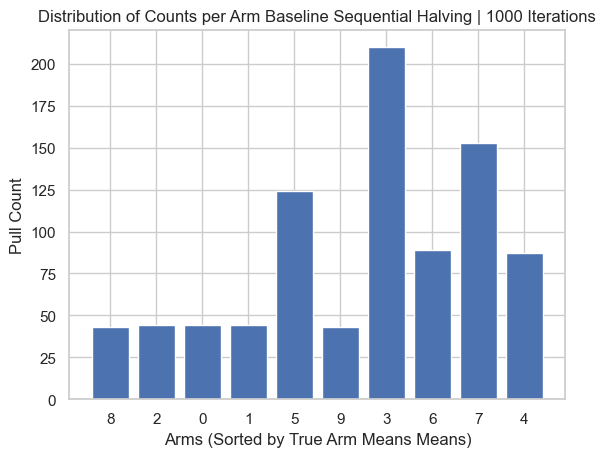

In [75]:
frequencies = [history.count(i) for i in range(k)]

# Sort arms based on their means
sorted_indices = sorted(range(k), key=lambda x: arm_means[0, x])
sorted_frequencies = [frequencies[i] for i in sorted_indices]

# Plotting the distribution of counts per arm in ascending order
plt.bar(range(k), sorted_frequencies, tick_label=[f'{i}' for i in sorted_indices])
plt.xlabel('Arms (Sorted by True Arm Means Means)')
plt.ylabel('Pull Count')
plt.title(f'Distribution of Counts per Arm Baseline Sequential Halving | {time_steps_per_problem} Iterations')
plt.show()

## Time-based Sequential Halving Algorithm

In [70]:
import math
import time


class SequentialHalvingAlgTime_v1:
  """
  Baseline sequential halving algorithm using a time based budget (inspired by Karnin et al., 2013).
  """
  
  rounds = math.ceil(math.log2(k)) - 1 #Amount of rounds to be used in the algorithm/amount of times the amount of considered arms will be halved
  
  def __init__(self, time_budget, return_hist=False):
      self.current_arms = range(k) #A list of all arms that the algorithm cares about. Will be sequentially halved ;)
      self.current_arm = self.current_arms[0] #Keeping track of the current arm to pull
      self.current_rewards = [0] * k #The rewards that the algorithm has observed for each arm
      self.visits = [0] * k #The amount of times that the algorithm has pulled each arm
      self.total_rewards = [0] * k #The total rewards that the algorithm has observed for each arm
      self.considered_arms_amt = k #The amount of arms that the algorithm is currently considering
      
      self.time_budget = time_budget
      self.sample_count_per_arm = self.get_dist_per_arm(k) #Amount of times by which each arm should be sampled (as per Karnin et al algorithm).
      self.current_iteration = 0 
      
      self.budget_left = time_budget
      self.round_time = time_budget/2
      self.current_arm_idx = 0
      
      self.current_round = 1
      self.return_hist = return_hist
      self.hist = [] #Stores history of arms pulled
      self.current_time = int(round(time.time() * 1000))
      self.prev_switch_time = self.current_time
      self.start_time = self.current_time

  
  
  """
  Retruns the amount of time to be allocated to each arm.
  """
  def get_dist_per_arm(self, num_arms):
      return math.floor(self.time_budget/(num_arms*math.ceil(math.log2(num_arms))))
    
  
  def reset(self) -> None:
    self.current_arms = range(k)
    self.current_arm = self.current_arms[0]
    self.current_rewards = [0] * k
    self.visits = [0] * k 
    self.total_rewards = [0] * k 
    self.considered_arms_amt = k
    self.sample_count_per_arm = self.get_dist_per_arm(k)
    self.budget_left = time_steps_per_problem
    self.current_round = 1
    self.hist = [] #Stores history of arms pulled
    self.budget_left = time_steps_per_problem
    self.current_time = int(round(time.time() * 1000))
  

  def choose_arm(self) -> int:
    #print(f"current_arm: {self.current_arm} current index: {self.current_arms.index(self.current_arm)} considered_arms_amt: {self.considered_arms_amt} current_round: {self.current_round} budget_left: {self.budget_left} sample_count_per_arm: {self.sample_count_per_arm} arms left: {len(self.current_arms)}")
    
    self.current_time = int(round(time.time() * 1000))
    #print(f"Current round: {self.current_round} round time: {self.round_time}")
    
    
    if(self.considered_arms_amt < 1): return self.current_arm
    
      #print(f"current_arms.index(self.current_arm): {self.current_arms.index(self.current_arm)}, considered_arms_amt: {self.considered_arms_amt}")
    # print(f"time elapsed: {self.current_time - self.prev_switch_time} round time: {self.round_time}")
    
    if self.current_time - self.prev_switch_time >= self.round_time:
      
      
      #If we have, we halve the amount of considered arms based on rewards and reset the current arm to the first arm in the list
      
      # Pair each arm with its corresponding reward, sort the pairs, and extract the arms
      self.current_arms, self.current_rewards = zip(*sorted(zip(self.current_arms, self.current_rewards), key=lambda x: x[1], reverse=True))
      self.current_arms = list(self.current_arms)
      self.current_rewards = list(self.current_rewards)
      self.round_time = self.round_time/2
      
      self.current_arms = self.current_arms[:math.ceil(self.considered_arms_amt/2)] #Take top half of the list
      self.current_rewards = self.current_rewards[:math.ceil(self.considered_arms_amt/2)]
      self.considered_arms_amt = len(self.current_arms)
      self.current_round = self.current_round + 1
      
      # self.budget_left = self.budget_left/2 #FIXME: Is this correct or should it be rounded up before use in the halving method?
      
      if self.considered_arms_amt == 1:
        self.sample_count_per_arm = self.budget_left
      else:
        self.sample_count_per_arm = self.get_dist_per_arm(self.considered_arms_amt)
      
      self.current_arm_idx = 0
      self.current_arm = self.current_arms[self.current_arm_idx]
      
      # print("here")
      if self.return_hist:
        self.hist.append("#") 
        self.hist.append(self.current_arm)
      self.prev_switch_time = int(round(time.time() * 1000))
      return self.current_arm
    
    
    self.current_arm = self.current_arms[self.current_arm_idx]
    
    
    
    if self.current_arm_idx == len(self.current_arms) - 1:
      self.current_arm_idx = 0
    else:
      self.current_arm_idx = self.current_arm_idx + 1
    
    
    if self.return_hist: self.hist.append(self.current_arm)
    
    self.current_time = int(round(time.time() * 1000))
    
    return self.current_arm

      

  def observe_reward(self, arm: int, reward: float) -> None:
    """
    This function lets us observe rewards from arms we have selected.

    :param arm: Index (starting at 0) of the arm we played.
    :param reward: The reward we received.
    
    """
    self.visits[self.current_arms.index(arm)] = self.visits[self.current_arms.index(arm)] + 1
    self.total_rewards[self.current_arms.index(arm)] = self.total_rewards[self.current_arms.index(arm)] + reward
    self.current_rewards[self.current_arms.index(arm)] = self.total_rewards[self.current_arms.index(arm)]/self.visits[self.current_arms.index(arm)]
    
    

  def __str__(self):
    return print(f"Sequential_halving:\nArm history: {self.hist}\n")

In [71]:


# for n in range(time_steps_per_problem):
#   seq_h.choose_arm()
  
rewards = []
time_budget = 10000 #milliseconds
seq_h_t = SequentialHalvingAlgTime_v1(time_budget, True)

start_time = int(round(time.time() * 1000))
while int(round(time.time() * 1000)) - start_time < time_budget:
    arm = seq_h_t.choose_arm()

    reward = norm.rvs(loc=arm_means[0,:][arm], scale=1.0)

    seq_h_t.observe_reward(arm, reward)
    rewards.append(reward)  
    time.sleep(0.01) #might not be needed but notebook freaks out if i dont have it
  
history = seq_h_t.hist
print(history)
seq_h_t.reset()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 

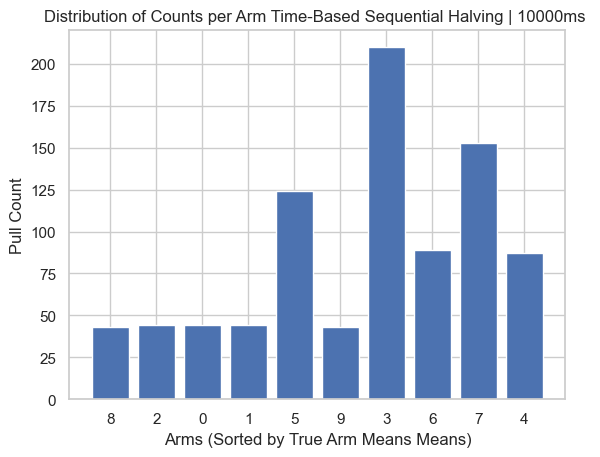

In [76]:
frequencies = [history.count(i) for i in range(k)]

# Sort arms based on their means
sorted_indices = sorted(range(k), key=lambda x: arm_means[0, x])
sorted_frequencies = [frequencies[i] for i in sorted_indices]

# Plotting the distribution of counts per arm in ascending order
plt.bar(range(k), sorted_frequencies, tick_label=[f'{i}' for i in sorted_indices])
plt.xlabel('Arms (Sorted by True Arm Means Means)')
plt.ylabel('Pull Count')
plt.title(f'Distribution of Counts per Arm Time-Based Sequential Halving | {time_budget}ms ')
plt.show()



****